Stock Price Prediction Using Python & Machine Learning

Saya akan menunjukkan bagaimana menulis program python untuk memprediksi harga saham dangan menggunakan MACHINE LEARNING
yang dinamakan Long Short-Term Memory (LSTM) 

Program ini sangat sederhana , setidaknya masih lebih baik dari pada menebak arah harga saham.


In [1]:
# untuk mengimport pandas data reader, 

kunjungi website https://anaconda.org/anaconda/pandas-datareader

In [2]:
# buka comand prompt lalu ketik conda install -c anaconda pandas-datareader, lalu enter

In [3]:
#Import the libraries
import math

import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, LSTM
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')

catatan dari website : https://pandas-datareader.readthedocs.io/en/latest/remote_data.html

di website ini ditunjukkan cara mengambil data dari sumber2 di bawah ini 

Functions from pandas_datareader.data and pandas_datareader.wb extract data from various Internet sources into a pandas DataFrame. Currently the following sources are supported:

Tiingo

IEX

Alpha Vantage

Econdb

Enigma

Quandl

St.Louis FED (FRED)

Kenneth French’s data library

World Bank

OECD

Eurostat

Thrift Savings Plan

Nasdaq Trader symbol definitions

Stooq

MOEX

Naver Finance

Yahoo Finance

I will get the stock quote for the company ‘Apple Inc.’ using the companies stock ticker (AAPL) from January 1st, 2012 to December 17th, 2019.

kita install dulu yfinance di command prompt

pip install yfinance --upgrade --no-cache-dir

In [9]:
import yfinance as yf

Code yg lama menggunakan 
df = web.DataReader('AAPL', data_source='yahoo', start='2012-01-01', end='2019-12-17'

tetapi ternyata terdapat error, 
sehingga cara untuk mendapat data dari yahoo diganti menjadi code dibawah ini :

In [12]:
df = pdr.get_data_yahoo("AAPL", start="2012-01-01", end="2019-12-17")
print(df)

                 High        Low       Open      Close       Volume  Adj Close
Date                                                                          
2012-01-03  14.732143  14.607143  14.621429  14.686786  302220800.0  12.591938
2012-01-04  14.810000  14.617143  14.642857  14.765714  260022000.0  12.659607
2012-01-05  14.948214  14.738214  14.819643  14.929643  271269600.0  12.800156
2012-01-06  15.098214  14.972143  14.991786  15.085714  318292800.0  12.933967
2012-01-09  15.276786  15.048214  15.196429  15.061786  394024400.0  12.913450
...               ...        ...        ...        ...          ...        ...
2019-12-11  67.775002  67.125000  67.202499  67.692497   78756800.0  66.701706
2019-12-12  68.139999  66.830002  66.945000  67.864998  137310400.0  66.871681
2019-12-13  68.824997  67.732498  67.864998  68.787498  133587600.0  67.780678
2019-12-16  70.197502  69.245003  69.250000  69.964996  128186000.0  68.940941
2019-12-17  70.442497  69.699997  69.892502  70.1025

In [13]:
df.shape

(2003, 6)

Buat Grafik untuk menvisualisasi data 

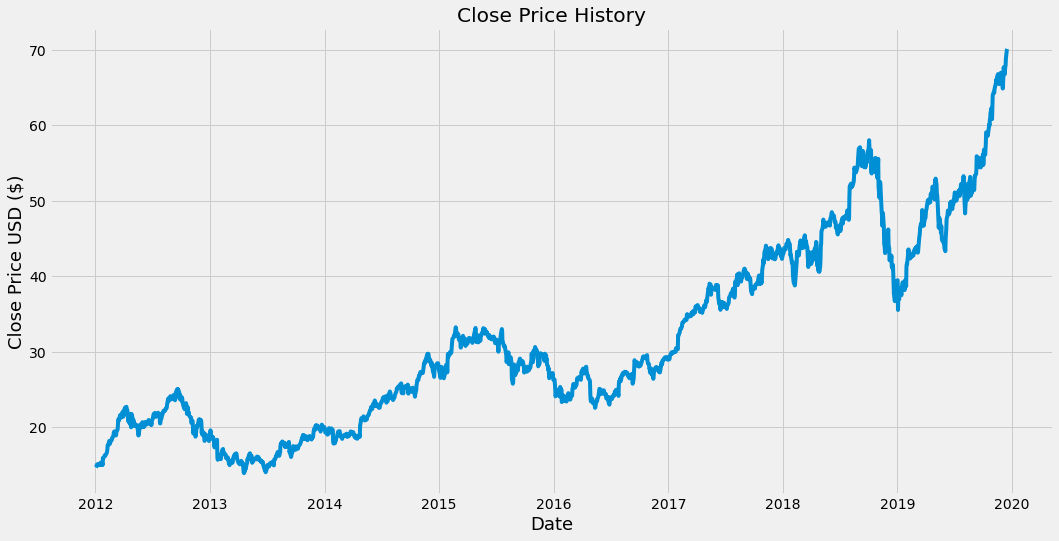

In [15]:
#Visualisasi harga penutupan saham 
plt.figure(figsize=(16,8))
plt.title('Close Price History')
plt.plot(df['Close'])
plt.xlabel('Date',fontsize=18)
plt.ylabel('Close Price USD ($)',fontsize=18)
plt.show()

Membuat sebuah data frame baru dengan hanya menunjukkan harga penutupan dan merubahnya menjadi sebuah array 
dengan fungsi data.value 

Kemudian kita buat sebuah variabel untuk menyimpan sejumlah data set Training.
Kita buat data set training berisi 80% data training


In [61]:
# membuat data frame baru dengan hanya memakai kolom Close saja / harga penutupan 

data = df.filter(['Close'])
# merubah data frame menjadi array

dataset = data.values
# membuat data training 80%

training_data_len = math.ceil( len(dataset) *.8) 

dari website : https://machinelearningmastery.com/standardscaler-and-minmaxscaler-transforms-in-python/

Banyak algoritma machine learning berkinerja lebih baik ketika variable inputnya di skala kan menjadi standar

termasuk algoritma yang menggunakan weighted sum seperti linier regression, dan k-nearest neighbors.

2 teknik yang populer untuk men skala data numerik adalah normalisasi dan standardisasi

Normalization menskala data menjadi 0 dan 1 
kalau Standardization menskala masing-masing data dengan mengurangi dengan nilai rata-rata dan membaginya dengan standar deviasi.


In [62]:
#Scale the all of the data to be values between 0 and 1 
scaler = MinMaxScaler(feature_range=(0, 1)) 
scaled_data = scaler.fit_transform(dataset)

Membuat training data set yang beirsi harga penutupan 60 hari terakhir yang akan kita gunakan untuk memprediksi harga penutupan pada hari ke 61 nya 

So the first column in the ‘x_train’ data set will contain values from the data set from index 0 to index 59 (60 values total) and the second column will contain values from the data set from index 1 to index 60 (60 values) and so on and so forth.

The ‘y_train’ data set will contain the 61st value located at index 60 for it’s first column and the 62nd value located at index 61 of the data set for it’s second value and so on and so forth.

In [18]:
#Create the scaled training data set 
train_data = scaled_data[0:training_data_len  , : ]
#Split the data into x_train and y_train data sets
x_train=[]
y_train = []
for i in range(60,len(train_data)):
    x_train.append(train_data[i-60:i,0])
    y_train.append(train_data[i,0])

Now convert the independent train data set ‘x_train’ and dependent train data set ‘y_train’ to numpy arrays so they can be used for training the LSTM model.

In [19]:
#Convert x_train and y_train to numpy arrays
x_train, y_train = np.array(x_train), np.array(y_train)

Reshape the data to be 3-dimensional in the form [number of samples, number of time steps, and number of features]. The LSTM model is expecting a 3-dimensional data set.

In [21]:
#Reshape the data into the shape accepted by the LSTM
x_train = np.reshape(x_train, (x_train.shape[0],x_train.shape[1],1))

Build the LSTM model to have two LSTM layers with 50 neurons and two Dense layers, one with 25 neurons and the other with 1 neuron.

In [22]:
#Build the LSTM network model
model = Sequential()
model.add(LSTM(units=50, return_sequences=True,input_shape=(x_train.shape[1],1)))
model.add(LSTM(units=50, return_sequences=False))
model.add(Dense(units=25))
model.add(Dense(units=1))

Compile the model using the mean squared error (MSE) loss function and the adam optimizer.

In [23]:
#Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

Train the model using the training data sets. Note, fit is another name for train. Batch size is the total number of training examples present in a single batch, and epoch is the number of iterations when an entire data set is passed forward and backward through the neural network.

In [24]:
#Train the model
model.fit(x_train, y_train, batch_size=1, epochs=1)

1543/1543 [==============================] - 20s 11ms/step - loss: 9.5535e-04


Create a test data set

In [25]:
#Test data set
test_data = scaled_data[training_data_len - 60: , : ]
#Create the x_test and y_test data sets
x_test = []
y_test =  dataset[training_data_len : , : ] #Get all of the rows from index 1603 to the rest and all of the columns (in this case it's only column 'Close'), so 2003 - 1603 = 400 rows of data
for i in range(60,len(test_data)):
    x_test.append(test_data[i-60:i,0])

Then convert the independent test data set ‘x_test’ to a numpy array so it can be used for testing the LSTM model.

In [26]:
#Convert x_test to a numpy array 
x_test = np.array(x_test)

Reshape the data to be 3-dimensional in the form [number of samples, number of time steps, and number of features]. This needs to be done, because the LSTM model is expecting a 3-dimensional data set.

In [27]:
#Reshape the data into the shape accepted by the LSTM
x_test = np.reshape(x_test, (x_test.shape[0],x_test.shape[1],1))

Now get the predicted values from the model using the test data.

In [28]:
#Getting the models predicted price values
predictions = model.predict(x_test) 
predictions = scaler.inverse_transform(predictions)#Undo scaling

Get the root mean squared error (RMSE), which is a good measure of how accurate the model is. A value of 0 would indicate that the models predicted values match the actual values from the test data set perfectly.

The lower the value the better the model performed. But usually it is best to use other metrics as well to truly get an idea of how well the model performed.

In [29]:
#Calculate/Get the value of RMSE
rmse=np.sqrt(np.mean(((predictions- y_test)**2)))
rmse

1.4008760689875563

Let’s plot and visualize the data.

<ipython-input-30-c1beac80e8e6>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid['Predictions'] = predictions


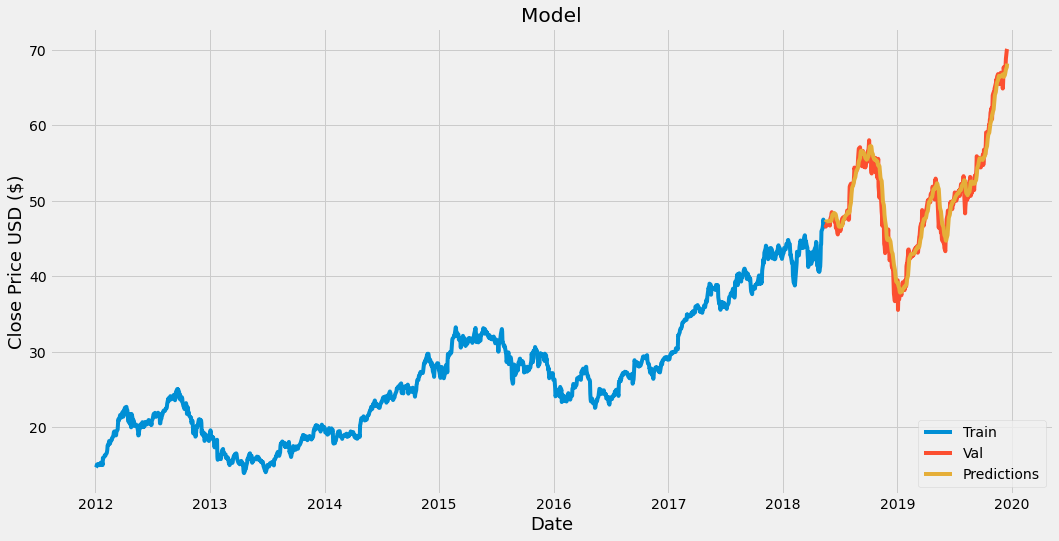

In [30]:
#Plot/Create the data for the graph
train = data[:training_data_len]
valid = data[training_data_len:]
valid['Predictions'] = predictions
#Visualize the data
plt.figure(figsize=(16,8))
plt.title('Model')
plt.xlabel('Date', fontsize=18)
plt.ylabel('Close Price USD ($)', fontsize=18)
plt.plot(train['Close'])
plt.plot(valid[['Close', 'Predictions']])
plt.legend(['Train', 'Val', 'Predictions'], loc='lower right')
plt.show()

Show the valid and predicted prices

In [31]:
#Show the valid and predicted prices
valid

,Close,Predictions
Date,,
2018-05-17,46.747501,47.168732
2018-05-18,46.577499,47.255096
2018-05-21,46.907501,47.266167
2018-05-22,46.790001,47.271732
2018-05-23,47.090000,47.259674
...,...,...
2019-12-11,67.692497,66.888390
2019-12-12,67.864998,67.113670
2019-12-13,68.787498,67.360291


I want to test the model some more and get the predicted closing price value of Apple Inc. for December 18, 2019 (12/18/2019).

So I will get the quote, convert the data to an array that contains only the closing price. Then I will get the last 60 day closing price and scale the data to be values between 0 and 1 inclusive.

After that I will create an empty list and append the past 60 day price to it, and then convert it to a numpy array and reshape it so that I can input the data into the model.

Last but not least, I will input the data into the model and get the predicted price.

In [56]:
apple_quote = pdr.get_data_yahoo("AAPL", start="2012-01-01", end="2019-12-17")


In [45]:
# Get the quote
# apple_quote = web.DataReader('AAPL', data_source='yahoo', start='2012-01-01', end='2019-12-17')

In [46]:
#Create a new dataframe
new_df = apple_quote.filter(['Close'])

In [47]:
#Get teh last 60 day closing price 
last_60_days = new_df[-60:].values

In [48]:
#Scale the data to be values between 0 and 1
last_60_days_scaled = scaler.transform(last_60_days)

In [49]:
#Create an empty list
X_test = []

In [50]:
#Append teh past 60 days
X_test.append(last_60_days_scaled)

In [51]:
#Convert the X_test data set to a numpy array
X_test = np.array(X_test)

In [52]:
#Reshape the data
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

In [53]:
#Get the predicted scaled price
pred_price = model.predict(X_test)

In [54]:
#undo the scaling 
pred_price = scaler.inverse_transform(pred_price)
print(pred_price)

[[68.66732]]


Now let’s see what the actual price for that day was.

In [59]:
apple_quote2 = pdr.get_data_yahoo("AAPL", start="2019-12-18", end="2019-12-18")
print(apple_quote2['Close'])

Date
2019-12-17    70.102501
2019-12-18    69.934998
Name: Close, dtype: float64
